In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime, timedelta

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, accuracy_score

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

#SBER_PATH = '/content/drive/MyDrive/Stock_Data/SBER_D_from_15_11_20_to_11_12_23.csv'
SBER_PATH = '/content/drive/MyDrive/Stock_Data/sber.csv'

def fix_stockdata(ticket):
    for i in range(len(ticket['Цена'])):

        price = ticket['Цена'].iloc[i]
        price = price.replace(',', '.')
        price = price.replace('.', '', price.count('.') - 1)
        ticket['Цена'].iloc[i] = price

        open = ticket['Откр.'].iloc[i]
        open = open.replace(',', '.')
        open = open.replace('.', '', open.count('.') - 1)
        ticket['Откр.'].iloc[i] = open

        max = ticket['Макс.'].iloc[i]
        max = max.replace(',', '.')
        max = max.replace('.', '', max.count('.') - 1)
        ticket['Макс.'].iloc[i] = max

        min = ticket['Мин.'].iloc[i]
        min = min.replace(',', '.')
        min = min.replace('.', '', min.count('.') - 1)
        ticket['Мин.'].iloc[i] = min

        volume = ticket['Объём'].iloc[i]
        volume = volume.replace(',', '.')
        volume = volume.replace('.', '', volume.count('.') - 1)
        if volume[len(volume) - 1] == 'K':
            volume = int(float(volume[:len(volume) - 1]) * 10**3)
        elif volume[len(volume) - 1] == 'M':
            volume = int(float(volume[:len(volume) - 1]) * 10**6)
        elif volume[len(volume) - 1] == 'B':
            volume = int(float(volume[:len(volume) - 1]) * 10**9)
        else:
            volume = int(float(volume))
        ticket['Объём'].iloc[i] = volume

        diff = ticket['Изм. %'].iloc[i]
        diff = diff.replace(',', '.')
        diff = float(diff[:len(diff) - 1])
        ticket['Изм. %'].iloc[i] = diff

    ticket['Цена'] = ticket['Цена'].astype(float)
    ticket['Откр.'] = ticket['Откр.'].astype(float)
    ticket['Макс.'] = ticket['Макс.'].astype(float)
    ticket['Мин.'] = ticket['Мин.'].astype(float)
    ticket['Объём'] = ticket['Объём'].astype(int)
    ticket['Изм. %'] = ticket['Изм. %'].astype(float)
    ticket['Дата'] = pd.to_datetime(ticket['Дата'], dayfirst=True).dt.normalize()

    ticket = ticket.set_index('Дата')

    return ticket

DATA = fix_stockdata(pd.read_csv(SBER_PATH))
DATA = DATA.rename(columns={'Дата' : 'date', 'Цена' : 'close', 'Откр.' : 'open', 'Макс.' : 'max', 'Мин.' : 'min', 'Объём' : 'volume', 'Изм. %' : 'return'})
DATA.index.rename('date', inplace=True)
DATA = DATA.sort_values(by='date', ascending=True)

Mounted at /content/drive


In [ ]:
def raw_reader(stock):
  COMMENTS = '/content/drive/MyDrive/Social_Media_Data/sber_raw/investing_dataset_'+stock.lower()+'_1-201.csv'

  storage_path = '/content/drive/MyDrive/Social_Media_Data/'+stock.lower()+'_raw/'
  SMD = pd.read_csv(storage_path + 'investing_dataset_'+stock.lower()+'_1-201.csv')
  for f in os.listdir(storage_path):
    if f != 'investing_dataset_'+stock.lower()+'_1-201.csv':
      SMD = pd.concat([SMD, pd.read_csv(storage_path + f)], ignore_index=True)

  SMD.drop(columns=SMD.columns[0], axis=1, inplace=True)
  SMD['date'] = pd.to_datetime(SMD['date'], dayfirst=True).dt.normalize()
  SMD['user_id'] = SMD['user_id'].astype(str)
  for i in range(len(SMD['user_id'])):
          id = SMD['user_id'].iloc[i]
          if len(id) == 11:
            id = id[:len(id)-2]
            SMD['user_id'].iloc[i] = id

  SMD.to_csv('/content/drive/MyDrive/Social_Media_Data/'+stock.lower()+'_investing_dataset.csv')
  print(stock.upper(), 'successfully saved')

stock = 'SBER'

if stock.lower()+'_investing_dataset.csv' in os.listdir('/content/drive/MyDrive/Social_Media_Data/'):
  print(stock, 'dataset already exists')
else:
  raw_reader(stock)

In [ ]:
def read_SMD(stock):
  SMD = pd.read_csv('/content/drive/MyDrive/Social_Media_Data/'+stock.lower()+'_investing_dataset.csv')
  SMD.drop(columns=SMD.columns[0], axis=1, inplace=True)
  SMD['date'] = pd.to_datetime(SMD['date']).dt.normalize()
  SMD['user_id'] = SMD['user_id'].astype(str)
  return SMD

DATA_SMD = read_SMD(stock)

Q = DATA_SMD['date'].value_counts()
N = pd.DataFrame([[date, Q[date]] for date in Q.keys()], columns=['date', 'comments'])
N = N.set_index('date')
N = N.sort_values(by='date', ascending=False)
DATA = DATA.join(N)
DATA = DATA.dropna()
DATA['comments'] = DATA['comments'].astype(int)

ValueError: columns overlap but no suffix specified: Index(['comments'], dtype='object')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Stock_Data/sber_dataset.csv'
dataset = pd.read_csv(PATH)
dataset['date'] = pd.to_datetime(dataset['date'])
dataset = dataset.set_index('date')
SBER = dataset.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SBER = DATA.copy()

In [ ]:
SBER

,close,open,max,min,volume,return,MA_7,MA_14,EMA_3,EMA_7,MACD,signal,histogram,comments,sentiment_sum,positive,negative,sentiment_index,sdi
date,,,,,,,,,,,,,,,,,,,
2020-11-20,239.42,239.58,240.77,236.57,48800000,-0.35,243.022857,232.672143,240.757507,239.958005,0.799503,3.350598,-2.551095,516.0,-58.052157,214,302,-0.343095,0.829457
2020-11-23,239.70,240.45,243.87,238.52,74830000,0.12,242.682857,235.186429,240.228754,239.893504,0.335250,2.345482,-2.010232,417.0,-59.901303,162,255,-0.451427,0.776978
2020-11-24,247.33,241.65,247.85,239.57,84520000,3.18,243.302857,237.910000,243.779377,241.752628,2.026749,2.239238,-0.212488,648.0,-105.930981,243,405,-0.509185,0.750000
2020-11-25,251.91,248.00,252.20,246.55,133400000,1.85,243.862857,240.425000,247.844688,244.291971,3.552718,2.677064,0.875653,905.0,-114.127359,377,528,-0.336094,0.833149
2020-11-26,250.10,252.30,252.88,247.44,79920000,-0.72,244.491429,242.753571,248.972344,245.743978,3.228366,2.860832,0.367535,872.0,-84.338924,373,499,-0.290352,0.855505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,276.80,279.36,280.56,276.20,29820000,-1.11,283.004286,282.368571,279.424429,281.315447,-1.891018,-0.242643,-1.648375,157.0,-24.370310,66,91,-0.317096,0.840764
2023-11-30,277.50,276.70,278.65,272.75,55870000,0.25,282.248571,282.176429,278.462215,280.361586,-1.899371,-0.794886,-1.104485,218.0,-14.439360,99,119,-0.182322,0.908257
2023-12-01,273.97,277.00,277.98,273.55,31660000,-1.27,280.507143,281.462143,276.216107,278.763689,-2.547582,-1.379118,-1.168464,167.0,-28.069680,67,100,-0.395613,0.802395


In [ ]:
ma_day = [3, 7, 14]
ema_day = [3, 7]

for ma in ma_day:
      column_name = f"MA_{ma}"
      SBER[column_name] = SBER['close'].rolling(ma).mean()
for ema in ema_day:
      column_name = f"EMA_{ema}"
      SBER[column_name] = SBER['close'].ewm(span=ema, adjust=False).mean()

macd = SBER['EMA_3'] - SBER['EMA_7']
signal = macd.ewm(span=5, adjust=False).mean()
histogram = macd - signal

SBER['MACD'] = macd
SBER['signal'] = signal
SBER['histogram'] = histogram

#px.line(SBER[['close','MA_7', 'EMA_7']])

In [ ]:
SBER = dataset.copy()

In [ ]:
SBER["tomorrow"] = SBER["return"].shift(-1)
SBER["target"] = (SBER["tomorrow"] > 0).astype(int)
SBER["tomorrow"] = SBER["close"].shift(-1)
SBER["naive"] = (SBER["return"] < 0).astype(int)
SBER["repeat"] = (SBER["return"] > 0).astype(int)

In [ ]:
SBER

,close,open,max,min,volume,return,MA_7,MA_14,EMA_3,EMA_7,...,comments,sentiment_sum,positive,negative,sentiment_index,sdi,tomorrow,target,naive,repeat
date,,,,,,,,,,,,,,,,,,,,,
2020-11-20,239.42,239.58,240.77,236.57,48800000,-0.35,243.022857,232.672143,240.757507,239.958005,...,516.0,-58.052157,214,302,-0.343095,0.829457,239.70,1,1,0
2020-11-23,239.70,240.45,243.87,238.52,74830000,0.12,242.682857,235.186429,240.228754,239.893504,...,417.0,-59.901303,162,255,-0.451427,0.776978,247.33,1,0,1
2020-11-24,247.33,241.65,247.85,239.57,84520000,3.18,243.302857,237.910000,243.779377,241.752628,...,648.0,-105.930981,243,405,-0.509185,0.750000,251.91,1,0,1
2020-11-25,251.91,248.00,252.20,246.55,133400000,1.85,243.862857,240.425000,247.844688,244.291971,...,905.0,-114.127359,377,528,-0.336094,0.833149,250.10,0,0,1
2020-11-26,250.10,252.30,252.88,247.44,79920000,-0.72,244.491429,242.753571,248.972344,245.743978,...,872.0,-84.338924,373,499,-0.290352,0.855505,251.59,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,276.80,279.36,280.56,276.20,29820000,-1.11,283.004286,282.368571,279.424429,281.315447,...,157.0,-24.370310,66,91,-0.317096,0.840764,277.50,1,1,0
2023-11-30,277.50,276.70,278.65,272.75,55870000,0.25,282.248571,282.176429,278.462215,280.361586,...,218.0,-14.439360,99,119,-0.182322,0.908257,273.97,0,0,1
2023-12-01,273.97,277.00,277.98,273.55,31660000,-1.27,280.507143,281.462143,276.216107,278.763689,...,167.0,-28.069680,67,100,-0.395613,0.802395,270.96,0,1,0


In [ ]:
print("precision:",precision_score(SBER["target"], SBER["repeat"]))
print("recall:", recall_score(SBER["target"], SBER["repeat"]))
print("accuracy:", accuracy_score(SBER["target"], SBER["repeat"]))
print(SBER['target'].value_counts())
print(SBER['repeat'].value_counts())

precision: 0.47668393782383417
recall: 0.4754521963824289
accuracy: 0.4519621109607578
target
1    387
0    352
Name: count, dtype: int64
repeat
1    386
0    353
Name: count, dtype: int64


In [ ]:
print("precision:",precision_score(SBER["target"], SBER["naive"]))
print("recall:", recall_score(SBER["target"], SBER["naive"]))
print("accuracy:", accuracy_score(SBER["target"], SBER["naive"]))
print(SBER['target'].value_counts())
print(SBER['naive'].value_counts())

precision: 0.5747126436781609
recall: 0.5167958656330749
accuracy: 0.5466847090663058
target
1    387
0    352
Name: count, dtype: int64
naive
0    391
1    348
Name: count, dtype: int64


In [ ]:
SBER = SBER.dropna()

In [ ]:
train_length = int(np.ceil( len(SBER) * .85 ))
WINDOW = 30

predictors = ["close", "volume", "return", "MACD", "signal", "histogram"]
predictors = ['close', 'return','open', 'max', 'min', 'volume', 'MA_7', 'MA_14',
       'EMA_3', 'EMA_7', 'MACD', 'signal', 'histogram', 'comments', 'sdi', 'sentiment_index']
target = ['tomorrow']

# **LSTM**

In [ ]:
dataset = SBER[predictors].values
target = SBER[target].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)
scaled_target = scaler.fit_transform(target)

train_x = scaled_dataset[:train_length, :]
test_x = scaled_dataset[train_length:,:]
train_y = scaled_target[:train_length, :]
test_y = target[train_length:,:]

In [ ]:
X = []
Y = []
for i in range(WINDOW, train_length):
    X.append(train_x[i-WINDOW:i, :])
    Y.append(train_y[i - 1, 0])

X, Y = np.array(X), np.array(Y)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X, Y, epochs = 20, batch_size = 1)

Epoch 1/20
599/599 [==============================] - 27s 34ms/step - loss: 0.0146
Epoch 2/20
599/599 [==============================] - 21s 35ms/step - loss: 0.0097
Epoch 3/20
599/599 [==============================] - 20s 33ms/step - loss: 0.0069
Epoch 4/20
599/599 [==============================] - 23s 38ms/step - loss: 0.0065
Epoch 5/20
599/599 [==============================] - 20s 33ms/step - loss: 0.0050
Epoch 6/20
599/599 [==============================] - 19s 32ms/step - loss: 0.0057
Epoch 7/20
599/599 [==============================] - 20s 34ms/step - loss: 0.0048
Epoch 8/20
599/599 [==============================] - 20s 34ms/step - loss: 0.0046
Epoch 9/20
599/599 [==============================] - 19s 32ms/step - loss: 0.0040
Epoch 10/20
599/599 [==============================] - 19s 33ms/step - loss: 0.0035
Epoch 11/20
599/599 [==============================] - 21s 35ms/step - loss: 0.0038
Epoch 12/20
599/599 [==============================] - 19s 32ms/step - loss: 0.0033
E

In [ ]:
X_test, Y_test = [], []

for i in range(WINDOW, len(test_x)):
  X_test.append(test_x[i-WINDOW:i, :])
  Y_test.append(test_y[i - 1, 0])

X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [ ]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)

3/3 [==============================] - 3s 22ms/step


In [ ]:
valid = SBER[-len(preds):]
valid = valid[['close', 'tomorrow', 'target', 'naive']]
valid['pred'] = preds
#valid = valid[1:]
valid['actual'] = test_y[30:]
valid['actual'] = valid['pred'].shift(-1)
valid['target_pred'] = (valid['pred'] < valid['actual']).astype(int)

In [ ]:
valid

,close,tomorrow,target,naive,pred,actual,target_pred
date,,,,,,,
2023-08-15,260.42,256.02,0,1,259.899628,256.759491,0
2023-08-16,256.02,258.50,1,1,256.759491,255.268524,0
2023-08-17,258.50,261.14,1,0,255.268524,253.796982,0
2023-08-18,261.14,261.15,0,0,253.796982,253.464157,0
2023-08-21,261.15,261.45,1,0,253.464157,256.178589,1
...,...,...,...,...,...,...,...
2023-11-28,279.91,276.80,0,1,283.912872,282.754303,0
2023-11-29,276.80,277.50,1,1,282.754303,280.781433,0
2023-11-30,277.50,273.97,0,0,280.781433,277.575775,0


In [ ]:
print("precision:",precision_score(valid["target"], valid["naive"]))
print("recall:", recall_score(valid["target"], valid["naive"]))
print("accuracy:", accuracy_score(valid["target"], valid["naive"]))
print(valid['target'].value_counts())
print(valid['naive'].value_counts())

precision: 0.6285714285714286
recall: 0.4888888888888889
accuracy: 0.55
target
1    45
0    35
Name: count, dtype: int64
naive
0    45
1    35
Name: count, dtype: int64


In [ ]:
print("precision:",precision_score(valid["target"], valid["target_pred"]))
print("recall:", recall_score(valid["target"], valid["target_pred"]))
print("accuracy:", accuracy_score(valid["target"], valid["target_pred"]))
print(valid['target'].value_counts())
print(valid['target_pred'].value_counts())

precision: 0.5957446808510638
recall: 0.6222222222222222
accuracy: 0.55
target
1    45
0    35
Name: count, dtype: int64
target_pred
1    47
0    33
Name: count, dtype: int64


In [ ]:
px.line(valid[['tomorrow', 'pred']])

In [ ]:
valid

,close,tomorrow,target,naive,pred,actual,target_pred
date,,,,,,,
2023-08-15,260.42,256.02,0,1,259.899628,258.50,0
2023-08-16,256.02,258.50,1,1,256.759491,261.14,1
2023-08-17,258.50,261.14,1,0,255.268524,261.15,1
2023-08-18,261.14,261.15,0,0,253.796982,261.45,1
2023-08-21,261.15,261.45,1,0,253.464157,256.40,1
...,...,...,...,...,...,...,...
2023-11-28,279.91,276.80,0,1,283.912872,277.50,0
2023-11-29,276.80,277.50,1,1,282.754303,273.97,0
2023-11-30,277.50,273.97,0,0,280.781433,270.96,0


# **RANDOM FOREST**

In [ ]:
SBER

,close,open,max,min,volume,return,MA_3,MA_7,MA_14,EMA_3,EMA_7,MACD,signal,histogram,tomorrow,target_d2,target,naive,repeat
date,,,,,,,,,,,,,,,,,,,
2016-01-04,98.01,101.00,101.78,97.94,51260000,-3.21,100.363333,100.991429,100.584286,99.643910,100.345001,-0.701091,-0.134499,-0.566592,98.89,1,1,1,0
2016-01-05,98.89,97.88,99.24,97.16,49070000,0.90,99.386667,100.410000,100.669286,99.266955,99.981250,-0.714296,-0.327764,-0.386531,96.85,0,0,0,1
2016-01-06,96.85,98.70,99.56,96.83,40710000,-2.06,97.916667,99.767143,100.444286,98.058477,99.198438,-1.139960,-0.598496,-0.541464,91.03,0,0,1,0
2016-01-11,91.03,93.61,94.89,91.01,86120000,-6.01,95.590000,98.294286,99.628571,94.544239,97.156328,-2.612090,-1.269694,-1.342395,91.71,1,1,1,0
2016-01-12,91.71,89.09,92.88,88.52,110110000,0.75,93.196667,97.081429,98.768571,93.127119,95.794746,-2.667627,-1.735672,-0.931955,91.50,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-25,183.30,182.42,183.47,179.04,34730000,-0.54,184.796667,185.920000,188.397143,184.612662,186.134097,-1.521435,-1.173879,-0.347556,183.40,1,1,1,0
2018-12-26,183.40,183.90,185.50,182.35,30130000,0.05,183.666667,186.077143,187.769286,184.006331,185.450573,-1.444242,-1.264000,-0.180242,185.00,1,1,0,1
2018-12-27,185.00,187.40,187.40,184.18,47530000,0.87,183.900000,185.848571,187.054286,184.503165,185.337929,-0.834764,-1.120921,0.286157,186.50,0,1,0,1


In [ ]:
train = SBER.iloc[:train_length]
test = SBER.iloc[train_length:]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, min_samples_split=100, random_state=1)
model.fit(train[predictors], train["target"])

from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

print("precision:",precision_score(test["target"], preds))
print("recall:", recall_score(test["target"], preds))
print("accuracy:", accuracy_score(test["target"], preds))
print('real:\n', test['target'].value_counts(), '\npredicted:\n', preds.value_counts())

precision: 0.5277777777777778
recall: 0.6229508196721312
accuracy: 0.4818181818181818
real:
 target
1    61
0    49
Name: count, dtype: int64 
predicted:
 1    72
0    38
Name: count, dtype: int64


<Axes: xlabel='date'>

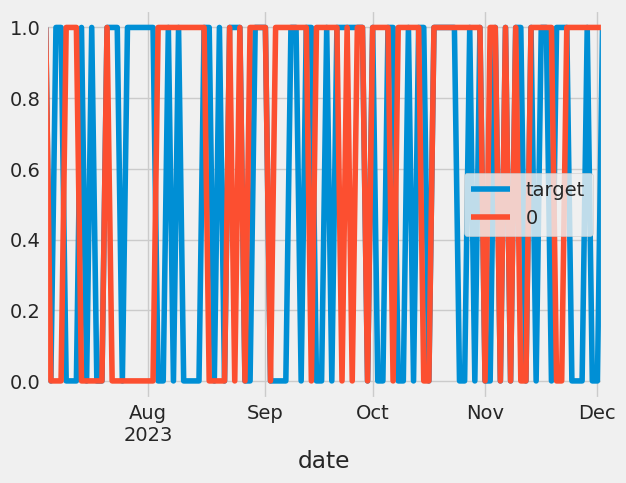

In [ ]:
combined = pd.concat([test["target"], preds], axis=1)
combined.plot()

# **CATBOOST**

In [ ]:
train = SBER.iloc[:train_length]
test = SBER.iloc[train_length:]

predictors = ["close", "return", "volume"]

In [ ]:
!pip install catboost

import pandas as pd
from catboost import CatBoostClassifier, Pool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.9 MB/s eta 0:00:00


In [ ]:
train_pool = Pool(data=train[predictors], label=train['target'])
test_pool = Pool(data=test[predictors])

In [ ]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=12)
model.fit(train_pool)

0:	learn: 0.6790699	total: 157ms	remaining: 2m 36s
1:	learn: 0.6598237	total: 318ms	remaining: 2m 38s
2:	learn: 0.6439417	total: 446ms	remaining: 2m 28s
3:	learn: 0.6291650	total: 559ms	remaining: 2m 19s
4:	learn: 0.6165591	total: 650ms	remaining: 2m 9s
5:	learn: 0.6068469	total: 769ms	remaining: 2m 7s
6:	learn: 0.5982610	total: 884ms	remaining: 2m 5s
7:	learn: 0.5868183	total: 999ms	remaining: 2m 3s
8:	learn: 0.5753452	total: 1.12s	remaining: 2m 3s
9:	learn: 0.5683715	total: 1.22s	remaining: 2m
10:	learn: 0.5628784	total: 1.28s	remaining: 1m 54s
11:	learn: 0.5531539	total: 1.4s	remaining: 1m 55s
12:	learn: 0.5450465	total: 1.52s	remaining: 1m 55s
13:	learn: 0.5352389	total: 1.61s	remaining: 1m 53s
14:	learn: 0.5253968	total: 1.69s	remaining: 1m 51s
15:	learn: 0.5179560	total: 1.76s	remaining: 1m 48s
16:	learn: 0.5143867	total: 1.86s	remaining: 1m 47s
17:	learn: 0.5086255	total: 1.94s	remaining: 1m 46s
18:	learn: 0.5014004	total: 2.04s	remaining: 1m 45s
19:	learn: 0.4939223	total: 2.12

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(test_pool)
preds = pd.Series(preds, index=test.index)

print("precision:",precision_score(test["target"], preds))
print("recall:", recall_score(test["target"], preds))
print("accuracy:", accuracy_score(test["target"], preds))
print('real:\n', test['target'].value_counts(), '\npredicted:\n', preds.value_counts())

precision: 0.6029411764705882
recall: 0.6721311475409836
accuracy: 0.5727272727272728
real:
 target
1    61
0    49
Name: count, dtype: int64 
predicted:
 1    68
0    42
Name: count, dtype: int64


<Axes: xlabel='date'>

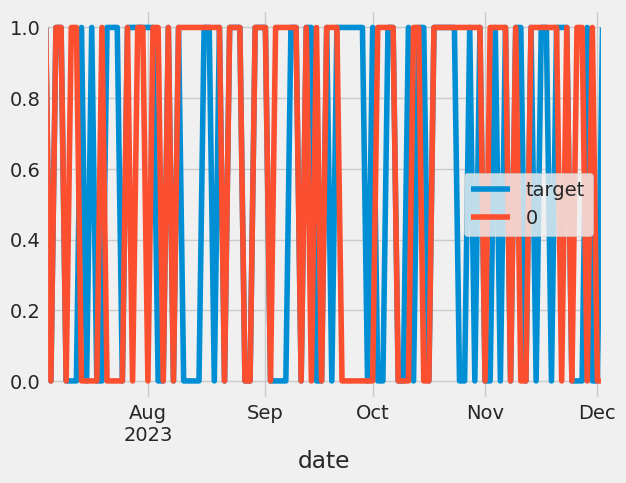

In [ ]:
combined = pd.concat([test["target"], preds], axis=1)
combined.plot()